## Cargar matrices

In [1]:
1 + 1

2

In [3]:
using MAT
using ReachabilityAnalysis
using Plots
using SparseArrays
using LinearAlgebra

LazySets.set_ztol(Float64, 1e-30)

1.0e-30

In [9]:
# cargar matrix K con los grados de libertad reducidos
# tiene 528 vertices => 1056 dof, y 3 dof son fijos => tamano 1053 x 1053
d = matread("ONSAS_call/output/matrices.mat")

Dict{String, Any} with 2 entries:
  "KTred"      => …
  "massMatred" => …

In [10]:
K = d["KTred"]
M = d["massMatred"];

In [11]:
m = size(K, 1)

1053

In [12]:
extrema(K)

(-1.8050574110768557e9, 4.001062862730709e9)

In [13]:
extrema(M)

(0.0, 0.024367093624706338)

In [8]:
# CITAR en presentacion: ...
#
# parametro promedio del tejido mamario
# E = 40e6  # 40 MPa
# nu = 0.49 # poisson
# rho = 950 # densidad kg/m^3
# nelem = 1000  # aproximado, ver GMSH
# atot = 0.1 * 0.05
# aux = rho * atot / (3*nelem) * 6
# la matriz de masa es la identidad
# M = sparse(Matrix(aux * I, m, m));

## Definir fuerza externa

In [14]:
# fuerza inicial es un Heaviside aplicado en el punto 4

# dof especiales:
# punto 1, abajo izq -> (1, 2)
# punto 2, abajo der -> (3, 4)
# punto 3, arriba der -> (5, 6)
# punto 4, centro arriba -> (7, 8)

# los puntos sgte son fijos: 1, 2, 4

In [15]:
Heaviside(t) = t >= 0 ? 1 : 0

# funcion auxiliar que devuelve el factor de carga aplico en la coordenada coord
function factor_de_carga(m, NSTEPS; T=1.0, coord=5, func=Heaviside)
    tiempos = range(0.0, T, length=NSTEPS)
    
    F = Vector{Vector{Float64}}(undef, NSTEPS)
    for i in 1:NSTEPS
        aux = zeros(m)
        aux[coord] = func(tiempos[i])
        
        F[i] = aux
    end
    return F
end

factor_de_carga (generic function with 1 method)

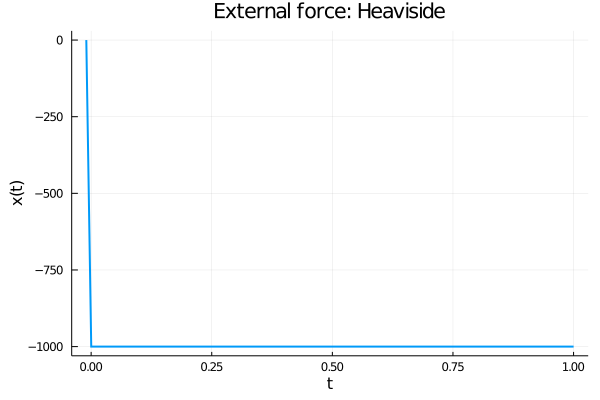

In [16]:
H = Heaviside

fHeav(t) = -1e3 * H(t)

tsp = range(-1e-2, 1.0, length=100)
plot(tsp, t -> fHeav.(t), xlab="t", ylab="x(t)", lw=2.0, lab="", title="External force: Heaviside")

$$
F_{rickler}(t) = 1\times10^3 \left( H(0.00015-t) - 3H(0.0001-t) + 3H(0.00005-t) \right)
$$

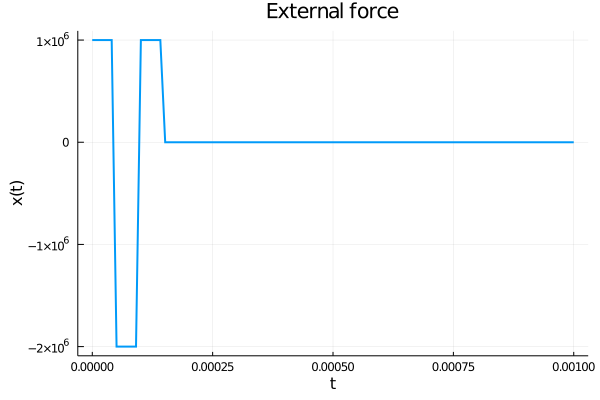

In [17]:
fr(t) = 1e6 * (H(0.00015-t) - 3*H(0.0001-t) + 3*H(0.00005-t))

tsp = range(-1e-7, 0.001, length=100)
plot(tsp, t -> fr.(t), xlab="t", ylab="x(t)", lw=2.0, lab="", title="External force")

## Solucion con los metodos numericos

In [18]:
# 5 es el dof vertical del nodo que recibe la carga
#
# 87 * 2 - 3 = 171 es el dof vertical de un nodo cerca de la interfaz

In [19]:
using StructuralDynamicsODESolvers

In [22]:
F = zeros(m); F[5] = -1e6

R_heav = factor_de_carga(m, 1001; T=1e-3, coord=5, func=t -> -1e6 * H(t));

R_ricker = factor_de_carga(m, 1001; T=1e-3, coord=5, func=fr);

In [23]:
C = spzeros(m, m)

# caso F constante
# sys = SecondOrderAffineContinuousSystem(M, C, K, F);

# caso F variable
#sys = SecondOrderConstrainedLinearControlContinuousSystem(M, C, K, Matrix(1.0I, m, m), Universe(m), R_heav)
sys = SecondOrderConstrainedLinearControlContinuousSystem(M, C, K, Matrix(1.0I, m, m), Universe(m), R_ricker)

prob = @ivp(sys, u(0) ∈ (zeros(m), zeros(m)))

alg = Trapezoidal(Δt=1e-6)

@time sol = solve(prob, alg, NSTEPS=1000);

  1.243335 seconds (34.41 k allocations: 240.052 MiB, 2.04% gc time, 1.07% compilation time)


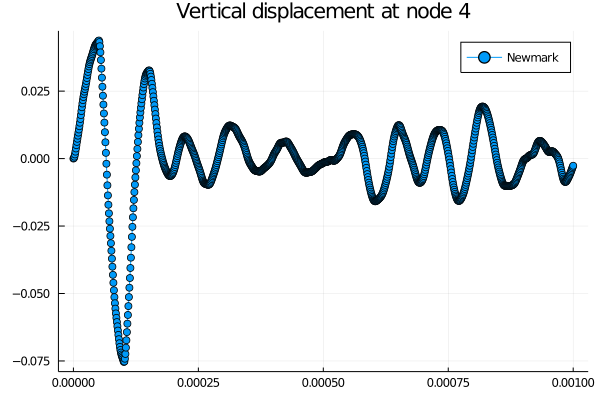

In [24]:
plot(sol, vars=(0, 5), title="Vertical displacement at node 4", lab="Newmark")

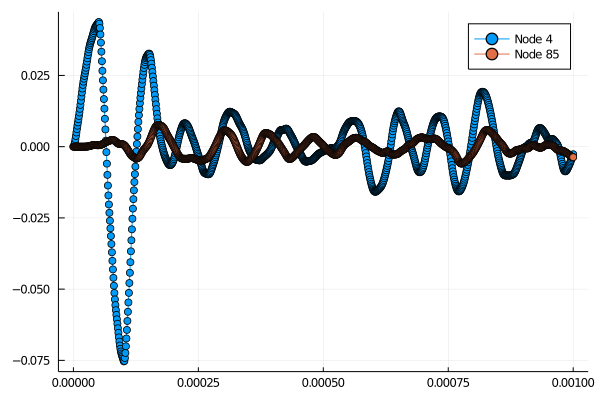

In [25]:
plot(sol, vars=(0, 5), lab="Node 4")

plot!(sol, vars=(0, 171), lab="Node 85")

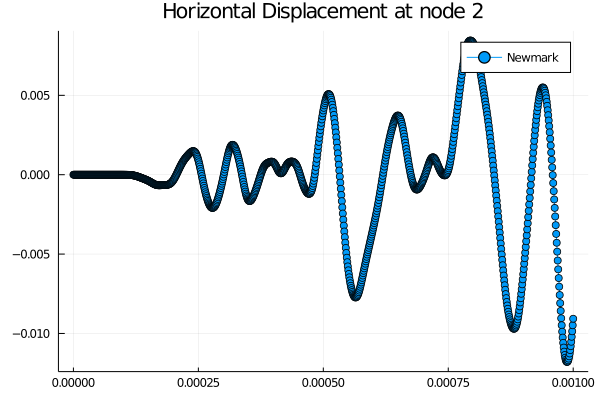

In [26]:
plot(sol, vars=(0, 1), title="Horizontal Displacement at node 2", lab="Newmark")

In [54]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/mforets/.julia/packages/Plots/uCh2y/src/backends.jl:372


Plots.PlotlyBackend()

## Plot en x-y

In [34]:
mesh = matread("ONSAS_call/mesh.mat")
coords = mesh["mesh"]["nodesCoords"]
connec = mesh["mesh"]["conecCell"];

In [49]:
size(coords)

(528, 3)

In [42]:
xcoords = coords[:, 1]
ycoords = coords[:, 2]
undeformed = UnionSetArray([Singleton([x, y]) for (x, y) in zip(xcoords, ycoords)]);

In [50]:
528 * 2

1056

In [52]:
# debo agregar ceros en:
# 1, 2, 4

In [84]:
# dof libres
dof = collect(1:1056)
deleteat!(dof, [1, 2, 4]);

Ug = [zeros(1056) for _ in 1:length(sol.U)]
for i in 1:length(sol.U)
    Ug[i][dof] .= sol.U[i]
end

deformed = []
for k in 1:length(sol.U)
    xdispl = Ug[k][1:2:1056] + xcoords
    ydispl = Ug[k][2:2:1056] + ycoords
    push!(deformed, UnionSetArray([Singleton([x, y]) for (x, y) in zip(xdispl, ydispl)]))
end

In [218]:
deformed

1001-element Vector{Any}:
 UnionSetArray{Float64, Singleton{Float64, Vector{Float64}}}(Singleton{Float64, Vector{Float64}}[Singleton{Float64, Vector{Float64}}([0.0, 0.0]), Singleton{Float64, Vector{Float64}}([0.1, 0.0]), Singleton{Float64, Vector{Float64}}([0.1, 0.05]), Singleton{Float64, Vector{Float64}}([0.05, 0.05]), Singleton{Float64, Vector{Float64}}([0.0, 0.05]), Singleton{Float64, Vector{Float64}}([0.03, 0.025]), Singleton{Float64, Vector{Float64}}([0.05, 0.025]), Singleton{Float64, Vector{Float64}}([0.004999999999990304, 0.0]), Singleton{Float64, Vector{Float64}}([0.009999999999982485, 0.0]), Singleton{Float64, Vector{Float64}}([0.01499999999997172, 0.0])  …  Singleton{Float64, Vector{Float64}}([0.03838515280749359, 0.03125870435294692]), Singleton{Float64, Vector{Float64}}([0.03480351122059164, 0.02801373226222748]), Singleton{Float64, Vector{Float64}}([0.04381654734234354, 0.01755741942582639]), Singleton{Float64, Vector{Float64}}([0.03682394646306696, 0.01929350828351552]), 

In [96]:
using Javis

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13490181936457977679\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1604492750740632438\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13490181936457977679\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Gtk-Message: 18:19:26.676: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:19:26.676: Failed to load module "pk-gtk-module"
Gtk-Message: 18:19:26.676: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:19:26.677: Failed to load module "pk-gtk-module"


In [107]:
function nfolds(x::AbstractVector, n::Int; rev=true)
    p = length(x)
    m = min(n, p)
    s = p / m
    out = [x[round(Int64, (i-1)*s)+1:min(p,round(Int64, i*s))] for i in 1:m]
    return rev ? reverse(out) : out
end

function ground(args...)
    background("white") # canvas background
    sethue("black") # pen color
end

tmax = 100
ntdiv = 100

# create empty video
vid = Video(500, 500)
Background(1:tmax, ground);

tdiv = nfolds(1:tmax, ntdiv)

# add objects to the canvas
for i in 1:tmax
    Object(tdiv[i], (args...) -> Javis.poly(100 .* [Luxor.Point(1.0, 1.0)], :stroke, close=true))
end

render(vid)

"javis_XD5ft1q.gif"

In [137]:
length(sol.U)

1001

In [139]:
function object(p=O, color="black")
    sethue(color)
    circle(p, 4, :fill)
    return p
end

myvideo = Video(800, 800)
Background(1:100, ground)

m = length(undeformed.array)
sc = 4000.

tdiv = nfolds(1:1001, 100)
#state = undeformed.array

for k in 1:length(tdiv)
    state = deformed[k[1]].array
    for i in 1:m
        xc = state[i].element[1] * sc - 200.
        yc = state[i].element[2] * sc

        Object(tdiv[k], (args...) -> object(Javis.O, "blue"), Point(xc, yc))
    end
end

render(myvideo)

┌ Warning: Some of the frames don't have a background. In this case: [992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 812, 813, 814, 815, 816, 817

"javis_QPej1RJ.gif"

┌ Info: Saved animation to 
│   fn = /home/mforets/Projects/SetPropagation-FEM-Examples/examples/InclusionWave/tmp.gif
└ @ Plots /home/mforets/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/home/mforets/Projects/SetPropagation-FEM-Examples/examples/InclusionWave/tmp.gif")
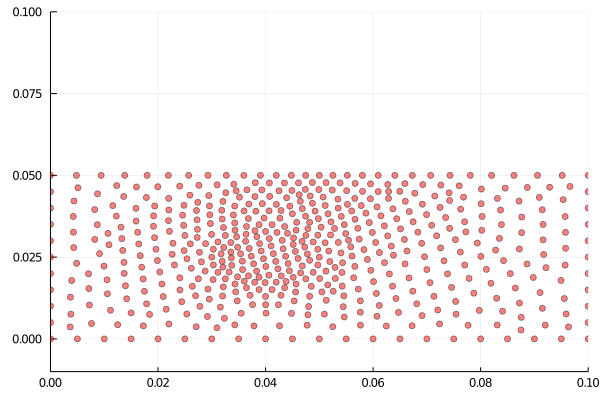

In [147]:
fig = plot(xlims=(0.0, 0.1), ylims=(-0.01, 0.1))
@gif for i ∈ 1:100
    plot!(fig, deformed[i], c=:red)
end every 10

In [154]:
h = box_approximation(ConvexHullArray([box_approximation(deformed[i]) for i in 1:length(deformed)]))

Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.047964351869861685, 0.03419177262821446], [0.06429838383273742, 0.05956568527322201])

In [160]:
a = h.center - h.radius

2-element Vector{Float64}:
 -0.016334031962875736
 -0.025373912645007546

In [161]:
b = h.center + h.radius

2-element Vector{Float64}:
 0.1122627357025991
 0.09375745790143647

In [195]:
using Printf

In [217]:
for i in 1:length(deformed)
    fig = plot(xlims=(a[1], b[1]), ylims=(a[2], b[2]))
    x = @sprintf("%05i", i)
    plot!(fig, deformed[i], c=:red)

    savefig(fig, "fig/deformed_$x.png")
end

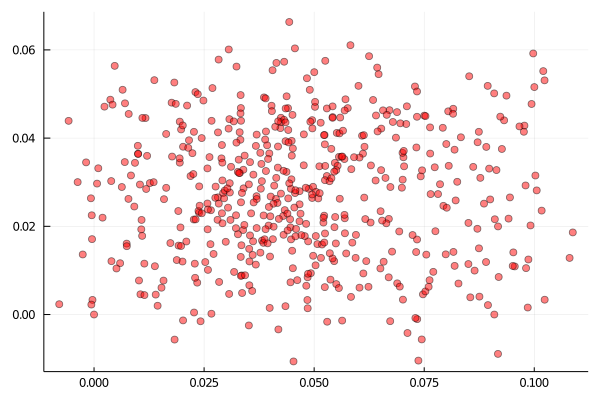

In [148]:
plot(undeformed, ratio=1.)
fig = plot()

plot!(fig, deformed[end], c=:red)

In [ ]:
eval(quote
using .Javis: Luxor, background, sethue, Video, Background, Object, render

export ground,
       luxify,
       nfolds

# default canvas background
function ground(args...)
    background("white") # canvas background
    sethue("black") # pen color
end

# convert a lazysets to a polygonal overapproximation with the given tolerance,
# and then to the function `poly` from Luxor.jl that receives array of points
function luxify(X::LazySet; tol=1e-3)

    # ε-close outer polygonal approximation of X
    P = overapproximate(X, HPolygon, tol)

    # convert to vertex representation
    V = convert(VPolygon, P)
    out = vertices_list(P)

    out_luxor = [Luxor.Point(Tuple(p)) for p in out]

    #return Luxor.poly(out_luxor, :stroke, close=true)
    return out_luxor
end

# useful function to split the array x into n equal parts (if possible)
# if the `rev` flag to return the partition in reverse order
# this function is useful to split in equal parts the animation time for an array of sets
function nfolds(x::AbstractVector, n::Int; rev=true)
    p = length(x)
    m = min(n, p)
    s = p / m
    out = [x[round(Int64, (i-1)*s)+1:min(p,round(Int64, i*s))] for i in 1:m]
    return rev ? reverse(out) : out
end

# animate an array of sets using Javis.jl
# TODO pass colors, eg. with default cols = Javis.distinguishable_colors(length(X))
function Javis.animate(X::AbstractVector{ST}; kwargs...) where {N, ST<:LazySet{N}}

    # size of the animation
    sz = get(kwargs, :size, (500, 500))

    # number of sets to render
    nsets = length(X)

    # maximum time of the animation
    tmax = get(kwargs, :tmax, 10*nsets)

    # number of time divisions (pass either an integer or a partition)
    ntdiv = get(kwargs, :ntdiv, nsets)
    tdiv = nfolds(1:tmax, ntdiv)

    # convert to Luxor.jl object
    Xlux = luxify.(X)

    # pick scaling factor
    α = get(kwargs, :scale, 50.0) # FIXME what is a good default? use radius of box_approximation(X[1]) ?

    # create empty video
    vid = Video(sz...)
    Background(1:tmax, ground)

    # add objects to the canvas
    for (dt, p) in zip(tdiv, Xlux)
        Object(dt, (args...) -> Javis.poly(α .* p, :stroke, close=true))
    end

    # render video
    render(vid)
end

end)


## Homogeneizar

In [ ]:
# homogeneization
m = size(M, 1)
Zm = zeros(m, m)
Im = Matrix(1.0I, m, m)
invM = inv(Matrix(M))

A = [Zm           Im;
    -invM*K       Zm];

# MX'' + KX = F
fscale = 1.0
F0 = vcat(zeros(m), invM * F * fscale)

n = 2m
Aext = zeros(n+1, n+1)
Aext[1:n, 1:n] .= A
Aext[1:n, n+1] .= F0
Aext = sparse(Aext)

S = @system(x' = Aext*x); # sistema homogeneizado

## Calculo preciso

In [ ]:
# ---------------
# PRIMER TRAMO
# ---------------
δt = dtn/20.
X0 = zeros(2m + 1)
X0[end] = 2e6
X0 = ReachSet(Singleton(X0), 0 .. 0)

@time Φ = exp(Matrix(state_matrix(ivp)) * δt); # Φ = exp(Aδ)
@show N1 = round(Int, 0.05 / δt)
Φ128 = Φ^128
X02 = ReachSet(linear_map(Φ128, set(X0)), interval(0.05));

# ---------------
# SEGUNDO TRAMO
# ---------------
X02.X.element[end] = -4e6;
X03 = ReachSet(linear_map(Φ128, set(X02)), interval(0.1));

# ---------------
# TERCER TRAMO
# ---------------
X03.X.element[end] = 2e6;
X04 = ReachSet(linear_map(Φ128, set(X03)), interval(0.15));